In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier

from scipy import sparse


In [2]:
columns = ["ID", "WORD", "LEMMA", "POS", "XPOS", "MORPH", "HEAD", "DEPREL", "DEPS", "MISC"]

# Read the file and convert it to a DataFrame
df = pd.read_csv('kdt-NLANU-0.01.connlu.txt\kdt-NLANU-0.01.connlu.txt', 
                 sep='\t', 
                 names=columns, 
                 skip_blank_lines=True)

# Drop rows where 'WORD' is NaN
df = df.dropna(subset=['WORD'])

df = df[df['POS'] != 'PUNCT']

df['ID'] = df['ID'].astype(int)

# Display the first few rows of the cleaned DataFrame
df.head()

<>:4: SyntaxWarning: invalid escape sequence '\k'
<>:4: SyntaxWarning: invalid escape sequence '\k'
C:\Users\Olivier\AppData\Local\Temp\ipykernel_7064\2258130061.py:4: SyntaxWarning: invalid escape sequence '\k'
  df = pd.read_csv('kdt-NLANU-0.01.connlu.txt\kdt-NLANU-0.01.connlu.txt',


,ID,WORD,LEMMA,POS,XPOS,MORPH,HEAD,DEPREL,DEPS,MISC
1,1,ҚТЖ,ҚТЖ,PROPN,PROPN,_,4,nsubj,_,_
2,2,халықаралық,халықаралық,ADJ,ADJ,_,3,amod,_,_
3,3,серіктестікті,серіктестік,NOUN,NOUN,Case=Acc,4,dobj,_,_
4,4,кеңейтуде,кеңей,VERB,VERB,Person=3|vbTense=Aor|vbVcCaus=True,0,root,_,_
6,1,160,160,NUM,NUM,_,2,compound,_,_


In [3]:
# Replace all numeric strings with '10'
def standardize_numbers(df_):
    df_['WORD'] = df_['WORD'].apply(lambda x: '10' if x.isdigit() else x)
    return df_
df = standardize_numbers(df)

In [4]:
def get_sentences(df_) : 
    
    df_ = df_.copy() # copy the input df

    # Grouping by ID and aggregating the words and POS tags
    df_['sentence'] = df_.groupby((df_['ID'] == 1).cumsum())['WORD'].transform(lambda x: ' '.join(x))
    df_['POS'] = df_.groupby((df_['ID'] == 1).cumsum())['POS'].transform(lambda x: ' '.join(x))

    # Filter out rows where ID is 1, as they are not part of the final sentences
    df_sentences = df_[df_['ID'] != 1][['sentence', 'POS']].reset_index(drop=True)

    # Remove duplicates
    df_sentences = df_sentences.drop_duplicates().reset_index(drop=True)

    return df_sentences

df_sentences = get_sentences(df)
"""
df_sentences = df_sentences.sample(n=1000, 
                                   random_state=2)"""

'\ndf_sentences = df_sentences.sample(n=1000, \n                                   random_state=2)'

In [5]:
df_sentences['length'] = df_sentences['sentence'].apply(len)

In [6]:
df_sentences['length'].describe()

count    28771.000000
mean       118.602794
std         86.921846
min          7.000000
25%         55.000000
50%         96.000000
75%        158.000000
max        865.000000
Name: length, dtype: float64

<Axes: title={'center': 'Sentence Length Distribution'}, ylabel='Frequency'>

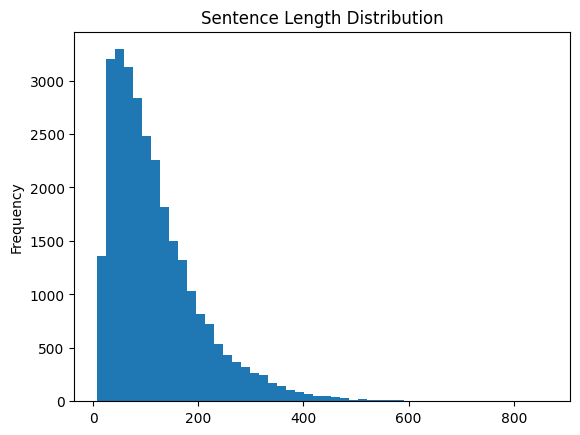

In [7]:
df_sentences['length'].plot(kind='hist', bins=50, title='Sentence Length Distribution')

In [8]:
print(df_sentences['length'].quantile(0.95))
Q95 = df_sentences['length'].quantile(0.95)

293.0


In [9]:
def delete_longer_sentence(df) :
    # Calculate the length of each sentence
    df['length'] = df['sentence'].apply(len)

    # Identify the index of the longest sentence
    condition = (df_sentences['length']>Q95)

    # Drop the longest sentence from the DataFrame
    df = df.drop(df[condition].index)

    # Optionally, you can drop the 'length' column if no longer needed
    df = df.drop(columns='length')

    return df

df_sentences = delete_longer_sentence(df_sentences)


In [10]:
def get_values(df):
    X_sent = df['sentence'].str.strip()
    X_sent = X_sent.values

    y_sent = df['POS'].str.strip()
    y_sent = y_sent.values

    return X_sent, y_sent

In [11]:
df_sentences.shape[0] # number of sentences

X_sent, y_sent = get_values(df_sentences)

max_sent_len=max([len(w) for w in X_sent])

X_train, X_test, y_train, y_test = train_test_split(X_sent, y_sent, test_size=0.1, random_state=42)

# TfidVectorizer with words model
vectorizer = TfidfVectorizer(lowercase=False, 
                            analyzer='word'
                            )

X = vectorizer.fit_transform(X_sent)

dic = vectorizer.get_feature_names_out() # word dictionary
dic = list(dic)


num_word = len(dic)
mx = X.T.dot(X) # word cooccurence matrix
mx = mx.toarray() #.astype(np.float16)


In [12]:
mx_sparse = sparse.csr_matrix(mx)
mx_sparse # 6700 x 6700 sparse matrix

: 

: 

In [41]:
def list_all_POS_tags(y) :
    list_tags = []
    for tag_list in y :
        tags = tag_list.split()
        for tag in tags :
            if tag not in list_tags :
                list_tags.append(tag)
    return list_tags

def set_up_POS_tag_encoder(list_tags) : 
    encoder_tag = LabelEncoder().fit(list_tags)
    return encoder_tag

list_tags = list_all_POS_tags(y = y_train)
encoder_tag = LabelEncoder().fit(list_tags)


#vec encoding of words
def alpha_vec2(w, mx, max_sent_len, dic):
        vec=np.zeros((max_sent_len,
                      len(dic)))
        
        words = w.split()
        for i in range(0, len(words)):

                word = words[i]

                if word in dic :
                        #print(mx[dic.index(word)])
                        vec[i]=mx[dic.index(word)]

        vec = vec.astype('float16').flatten()
        vec[vec == np.inf] = 0 
        vec[vec == -np.inf] = 0
        return vec


encoder_tag = set_up_POS_tag_encoder(list_tags)
#ordinal encoding of words

def alpha_vec2ord(w, max_sent_len, encoder_tag):
    vec=np.zeros(max_sent_len)
    words = w.split()
    encoded_tags = encoder_tag.transform(words)
    for i in range(len(encoded_tags)) : 
        vec[i]=encoded_tags[i]

    return vec.astype('int')

#ordinal decoding of words
def decode_vec(vec):
    w=''.join([chr(int(v)) for v in vec if v!=0])
    return w.strip()

In [42]:
max_sent_len

286

In [43]:
#Vectorize
X_sent_vec_train=[alpha_vec2(w, mx, max_sent_len, dic) for w in X_train]
Y_sent_vec_train=[alpha_vec2ord(w, max_sent_len, encoder_tag) for w in y_train]

X_sent_vec_test=[alpha_vec2(w, mx, max_sent_len, dic) for w in X_test]
Y_sent_vec_test=[alpha_vec2ord(w, max_sent_len, encoder_tag) for w in y_test]

In [46]:
X_sent_vec_train[0]

array([0.    , 0.    , 0.0276, ..., 0.    , 0.    , 0.    ], dtype=float16)

In [47]:
#Build model
best_model=ExtraTreesClassifier(n_estimators=10, n_jobs=5, criterion='entropy', bootstrap=True)

best_model.fit(X_sent_vec_train, Y_sent_vec_train)

#Test
predicts_test=best_model.predict(X_sent_vec_test)
predicts_train=best_model.predict(X_sent_vec_train)
test_acc=sum([sum(p==y)==max_sent_len for p,y in zip(predicts_test, Y_sent_vec_test)])/len(predicts_test)
train_acc=sum([sum(p==y)==max_sent_len for p,y in zip(predicts_train, Y_sent_vec_train)])/len(predicts_train)


In [49]:
for p,y in zip(predicts_test, Y_sent_vec_test) :
    print('y = ', y[0:15])
    print('p = ', p[0:15])
    print(sum(p==y)==max_sent_len)

y =  [ 7  0  7 14  7  0  0  0  0  0  0  0  0  0  0]
p =  [ 7 14  7  7  7  0  0  0  0  0  0  0  0  0  0]
False
y =  [ 6 11  7  7  2 14 10 14  2  7  7  7  1 11  7]
p =  [ 7  0  7  0  7  7 14  0 14  0  0  7  0  7  7]
False
y =  [7 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
p =  [ 7 14  0  0  0  0  0  0  0  0  0  0  0  0  0]
False
y =  [10  0  7 14  7  0  7  7  0  7  0  7  7 14  2]
p =  [11  7  7  7  7  7  0  7  7  0  0  7  0  0  0]
False
y =  [11 11  7 11 11  4  7  7  4 10 14  1 14  0  0]
p =  [ 7  7  2 11  7  7  0 14  4  7  2 14  7  0 14]
False
y =  [11  7  1  8  8  7 14  0  0  0  0  0  0  0  0]
p =  [7 7 7 7 0 7 0 0 0 0 0 0 0 0 0]
False
y =  [11 11  7  7 14  1  7  0 14  3  0  0  0  0  0]
p =  [ 7 14  7  0  0  7  0  0  0  0  0  0  0  0  0]
False
y =  [ 7  7  2  0  0  7 14  8  8  7  7 14 14 14  8]
p =  [ 7  7  7  7  7  7 14  7  8  7  0  0  0  7 14]
False
y =  [10  1  7  7  0  7  7  7 14  1  7 14  7  4  7]
p =  [ 7  7  7  7  7  7  0  7  0  7  7  7 14  4  7]
False
y =  [11 14  7  7 14  0  0  0  0  0  0  

In [ ]:
import pandas as pd
import numpy as np
from nltk import word_tokenize
import re

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#from sklearn.linear_model import LogisticRegression, LinearRegression, Lars, RidgeCV
#from sklearn.svm import SVC, SVR
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score

from tqdm import tnrange, tqdm_notebook
from time import sleep
import gc

from matplotlib import pyplot as plt
import os

from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

In [10]:
def get_lang(lang_code):
    ds=pd.read_csv('lang_codes_dic.csv',';')
    try:
        return ds[ds.Code==lang_code].iloc[0,1]
    except:
        return 'Undefined'


#vec encoding of words
def alpha_vec2(w, mx, max_word_len, dic):
    vec=np.zeros((max_word_len,len(dic)))    
    for i in range(0, len(w)):
        #print(i,w[i])
        vec[i]=mx[dic.index(w[i])]
        
    vec=vec.astype('float16').flatten()
    vec[vec==np.inf]=0 
    vec[vec==-np.inf]=0        
    return vec



#ordinal encoding of words
def alpha_vec2ord(w, max_word_len):
    vec=np.zeros(max_word_len)    
    for i in range(0, len(w)):        
        vec[i]=ord(w[i])    
    return vec.astype('int')

#ordinal decoding of words
def decode_vec(vec):
    w=''.join([chr(int(v)) for v in vec if v!=0])    
    return w.strip()

def lemm_model(dictionary_file):
    #load data
    lex = pd.read_csv('DS_lemm/'+ dictionary_file,'\t', encoding='utf8', names=['Lemma','Word_form'], keep_default_na=False)
    lang_code=dictionary_file[dictionary_file.index('-')+1:-4]
    lang=get_lang(lang_code)
    print('Language: ', lang, lang_code)
    number_words=lex.shape[0]
    
    X_lex=lex['Word_form'].str.strip()
    X_lex=X_lex.values
    
    Y_lex=lex['Lemma'].str.strip()
    Y_lex=Y_lex.values
    
    X_train, X_test, y_train, y_test = train_test_split(X_lex, Y_lex, test_size=0.1, random_state=42)
    
    #get max word length
    max_word_len=max(max([len(w) for w in Y_lex]),max([len(w) for w in X_lex]))
    
    #Char2vec model
    vectorizer = TfidfVectorizer(lowercase=False, analyzer='char')
    X = vectorizer.fit_transform(X_lex)
    dic=vectorizer.get_feature_names()#letter dictionary
    num_letters=len(dic)
    mx=X.T.dot(X)#letter cooccurence matrix
    mx=mx.toarray()
    
    #Vectorize
    X_lex_vec_train=[alpha_vec2(w, mx, max_word_len, dic) for w in X_train]
    Y_lex_vec_train=[alpha_vec2ord(w, max_word_len) for w in y_train]
    
    X_lex_vec_test=[alpha_vec2(w, mx, max_word_len, dic) for w in X_test]
    Y_lex_vec_test=[alpha_vec2ord(w, max_word_len) for w in y_test]
    
    #Build model
    best_model=ExtraTreesClassifier(n_estimators=10, n_jobs=5, criterion='entropy', bootstrap=True)
    
    best_model.fit(X_lex_vec_train, Y_lex_vec_train)
    
    #Test
    predicts_test=best_model.predict(X_lex_vec_test)
    predicts_train=best_model.predict(X_lex_vec_train)
    test_acc=sum([sum(p==y)==max_word_len for p,y in zip(predicts_test, Y_lex_vec_test)])/len(predicts_test)
    train_acc=sum([sum(p==y)==max_word_len for p,y in zip(predicts_train, Y_lex_vec_train)])/len(predicts_train)
    
    #Return results
    return test_acc, train_acc, max_word_len, num_letters, number_words, lang, lang_code, X_test, y_test

array(['алматыға', 'аулада', 'балалар', 'барды', 'басталды', 'болып',
       'біз', 'жүр', 'кітап', 'күн', 'мектепте', 'мен', 'ойнап', 'ол',
       'отырмын', 'оқып', 'сабақ', 'тауға', 'тұр', 'шуақты', 'шығамыз'],
      dtype=object)